<a href="https://colab.research.google.com/github/mazzeratziii/ML/blob/main/MO_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_path = '/content/drive/MyDrive/ColabFiles'
os.makedirs(save_path, exist_ok=True)


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ColabFiles/data_lab_1.csv")

# 1. предобработка данных
df = df[(df['price']>0) & (df['total_area']>0)].copy() # чистим данные (заводим новый датасет с реальными значениями у которых площадь и цена больше 0)
df['balcony'] = df['balcony'].fillna(0)
df['balcony'] = pd.to_numeric(df['balcony'], errors='coerce').fillna(0).astype(int) # если Nan считаем, что она 0
df['studio'] = df['studio'].map({True:1, False:0}).fillna(df['studio'])
df['studio'] = pd.to_numeric(df['studio'], errors='coerce').fillna(0).astype(int) # приводим в бинарное значение 1 0 (есть, нет)
for col in ['floor','floors_total']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
mask_bad_floor = (df['floor'].notna()) & (df['floors_total'].notna()) & (df['floor']>df['floors_total'])
df.loc[mask_bad_floor, 'floor'] = df.loc[mask_bad_floor, 'floors_total'] # находим аномалии например если этаж больше, чем этажность дома

In [ ]:
# 2. среднее значение(медиана)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('price')
imp = SimpleImputer(strategy='median')
df[num_cols] = imp.fit_transform(df[num_cols]) # меняем  пропущенные значения во всех столбцах, кроме столбца price на медианое значение

In [ ]:
# 3. выбросы
def cap_iqr(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    return s.clip(lower=q1 - 1.5*iqr, upper=q3 + 1.5*iqr)
for c in ['total_area','rooms','ceiling_height','living_area','kitchen_area',
          'airports_distance','centers_distance','parks_nearest','ponds_nearest','floor','floors_total']:
    if c in df.columns:
        df[c] = cap_iqr(df[c]) # находим выбросы по правилу Tukey и ибрезаем их до пороговых значений, делая их более устойчивыми для модели

In [ ]:
# 4. добавляем новые признаки(цена за кв.м, жилая часть, кухонная часть, относительный этаж)
df['price_per_sqm'] = df['price'] / df['total_area'] # более стабильный показатель чем абсолютная цена, потому что напрямую учитывает размер кв.
df['living_share'] = df['living_area'] / df['total_area'] # показывает насколько квартира рационально спланирована. Если жилая часть очень мала, значит коридоры большие ( не пойдёт)
df['kitchen_share'] = df['kitchen_area'] / df['total_area'] # тоже самое что и с жилой, если в маленькой квартире кухонная часть большая, значит жить мы будем в холодильнике или на плите(не оч)
df['floor_ratio'] = df['floor'] / df['floors_total'] # при выборе мы смотрим не на номер этажа, а его расположение. Первые этажы обычно дешевле, чем средние и последние
dist_cols = [c for c in ['airports_distance','centers_distance','parks_nearest','ponds_nearest'] if c in df.columns]
df['dist_mean'] = df[dist_cols].mean(axis=1) if dist_cols else np.nan # среднее расстояние до разных объектов (парк, метро, аэропорт)
df['has_balcony'] = (df['balcony']>0).astype(int) # признак есть ли балкон

In [ ]:
# 5. выбор функций
candidate_feats = ['total_area','rooms','ceiling_height','living_area','kitchen_area','floor','floors_total',
                   'has_balcony','studio','dist_mean','airports_distance','centers_distance','parks_nearest','ponds_nearest',
                   'living_share','kitchen_share','floor_ratio'] # выбираем с какими данными будем работать
candidate_feats = [c for c in candidate_feats if c in df.columns]
df_model = df.dropna(subset=candidate_feats + ['price_per_sqm']).copy() # копируем, чтобы не ловить варнинги

In [ ]:
# 6. моделируем ценку за кв.м
X = df_model[candidate_feats]; y = df_model['price_per_sqm'] # X - с чем работаем Y - цель
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # выделяем 20% данных на тест, остальное для обучения
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train); X_test_s = scaler.transform(X_test)
# строим две модели линейную и рандом форест
lr = LinearRegression().fit(X_train_s, y_train)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_s, y_train)

In [ ]:
# 7. метрики
y_pred_lr = lr.predict(X_test_s) # делаем прогноз по линейной
y_pred_rf = rf.predict(X_test_s) # делаем прогноз по форесту

print("LR R2", r2_score(y_test, y_pred_lr),
      "RMSE", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

print("RF R2", r2_score(y_test, y_pred_rf),
      "RMSE", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

LR R2 0.07751852913430657 RMSE 114923.59745021339
RF R2 0.191402940931517 RMSE 107596.08396363298


In [ ]:
# 8. важные характеристики
rf_imp = pd.Series(rf.feature_importances_, index=candidate_feats).sort_values(ascending=False)
lr_coef = pd.Series(lr.coef_, index=candidate_feats).sort_values(key=abs, ascending=False)
print("RF top features:\n", rf_imp.head(10))
print("Linear coef (by abs):\n", lr_coef.head(10))
# выводим топ 10 коэффиценты, которые показывают насколько сильно каждый признак снижает ошибку при построении деревьев

RF top features:
 total_area           0.177000
centers_distance     0.166431
airports_distance    0.135155
dist_mean            0.092211
floors_total         0.091678
rooms                0.074006
floor                0.055777
floor_ratio          0.055413
kitchen_share        0.032375
has_balcony          0.027464
dtype: float64
Linear coef (by abs):
 total_area           28015.666561
kitchen_share        17603.765784
centers_distance    -15434.820330
ceiling_height        4566.322642
airports_distance     4260.307753
floor                 4070.101722
kitchen_area         -3511.710309
rooms                 2642.378006
dist_mean            -2083.275241
living_area          -1870.610355
dtype: float64


In [ ]:
# 9. кластеризация
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaler.transform(df_model[candidate_feats]))
df_model['cluster'] = kmeans.labels_
for c in sorted(df_model['cluster'].unique()):
    sub = df_model[df_model['cluster']==c]
    if len(sub)<50:
        continue
    Xc = sub[candidate_feats]; yc = sub['price_per_sqm']
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
    sc = StandardScaler().fit(Xc_train)
    rf_c = RandomForestRegressor(n_estimators=150, random_state=42)
    rf_c.fit(sc.transform(Xc_train), yc_train)
    print(f"Cluster {c} size {len(sub)} - R2:", r2_score(yc_test, rf_c.predict(sc.transform(Xc_test))))
    print("Top features:", pd.Series(rf_c.feature_importances_, index=candidate_feats).sort_values(ascending=False).head(5).to_dict())
    # если простыми словами, то в разных ценовых диапазонах разные факторы определяют цену, в одном случае цена зависит от удаленности, в другом площадь и кол-во комнат

Cluster 0 size 10925 - R2: 0.5545783688760425
Top features: {'centers_distance': 0.5314179499188061, 'kitchen_share': 0.09869560098354475, 'living_share': 0.07561199507122926, 'floors_total': 0.05030030042221503, 'total_area': 0.04661717569885752}
Cluster 1 size 5205 - R2: 0.17199162148151337
Top features: {'rooms': 0.14866730588504867, 'airports_distance': 0.12629060639388182, 'centers_distance': 0.11323834017956284, 'total_area': 0.11062509790181115, 'dist_mean': 0.09657125494275638}
Cluster 2 size 7569 - R2: 0.5687193785183978
Top features: {'centers_distance': 0.4207996235462102, 'total_area': 0.08739834889570716, 'floors_total': 0.06601524389961183, 'kitchen_share': 0.06363261144178424, 'airports_distance': 0.06141556482270208}


In [ ]:
# 10. классификация
df_model['price_cat'] = pd.qcut(df_model['price_per_sqm'], q=3, labels=['cheap','mid','expensive'])
Xc = df_model[candidate_feats]; yc = df_model['price_cat']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
sc = StandardScaler().fit(Xc_train)
clf = RandomForestClassifier(n_estimators=200, random_state=42).fit(sc.transform(Xc_train), yc_train)
print(classification_report(yc_test, clf.predict(sc.transform(Xc_test))))
# тут мы создаем 3 категории, чтобы при предсказании цены мы могли её куда-то отнести

              precision    recall  f1-score   support

       cheap       0.83      0.76      0.79      1580
   expensive       0.75      0.76      0.76      1580
         mid       0.61      0.65      0.63      1580

    accuracy                           0.72      4740
   macro avg       0.73      0.72      0.73      4740
weighted avg       0.73      0.72      0.73      4740



In [ ]:

# 11. предсказанная цена за кв.м
y_pred_sqm = rf.predict(X_test_s)

y_pred_total = y_pred_sqm * X_test['total_area'].values # предсказанная общая цена квартиры

y_true_sqm = y_test.values # реальные значения
y_true_total = y_true_sqm * X_test['total_area'].values

comparison = pd.DataFrame({
    "real_price_per_sqm": y_true_sqm,
    "pred_price_per_sqm": y_pred_sqm,
    "real_total_price": y_true_total,
    "pred_total_price": y_pred_total,
    "total_area": X_test['total_area'].values
})  # выводим первые 10 примеров для проверки

print(comparison.head(10).round(0))


   real_price_per_sqm  pred_price_per_sqm  real_total_price  pred_total_price  \
0             85429.0             88304.0         2990000.0         3090650.0   
1            114848.0            110690.0         3790000.0         3652761.0   
2            113203.0            226674.0        12990000.0        26010789.0   
3            117236.0            134051.0         7210000.0         8244106.0   
4             15278.0             42508.0          550000.0         1530294.0   
5            110899.0            109362.0         5800000.0         5719614.0   
6             70968.0             99793.0         4400000.0         6187137.0   
7             86047.0             93264.0         5550000.0         6015504.0   
8             87059.0            303157.0         9990000.0        34787230.0   
9             82055.0             59909.0         5350000.0         3906078.0   

   total_area  
0        35.0  
1        33.0  
2       115.0  
3        62.0  
4        36.0  
5        52.

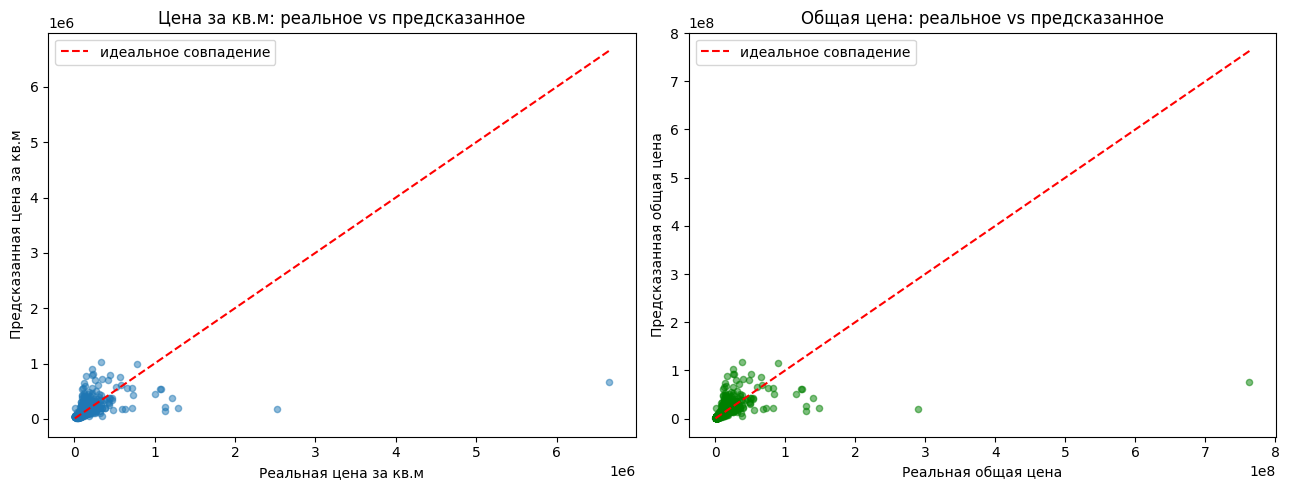

In [ ]:
import matplotlib.pyplot as plt

# 12. Визуализация
plt.figure(figsize=(13,5))

# График 1: цена за кв.м
plt.subplot(1,2,1)
plt.scatter(y_true_sqm, y_pred_sqm, alpha=0.5, s=20)
plt.plot([y_true_sqm.min(), y_true_sqm.max()],
         [y_true_sqm.min(), y_true_sqm.max()],
         'r--', label="идеальное совпадение")
plt.xlabel("Реальная цена за кв.м")
plt.ylabel("Предсказанная цена за кв.м")
plt.title("Цена за кв.м: реальное vs предсказанное")
plt.legend()

# График 2: общая цена
plt.subplot(1,2,2)
plt.scatter(y_true_total, y_pred_total, alpha=0.5, s=20, color="green")
plt.plot([y_true_total.min(), y_true_total.max()],
         [y_true_total.min(), y_true_total.max()],
         'r--', label="идеальное совпадение")
plt.xlabel("Реальная общая цена")
plt.ylabel("Предсказанная общая цена")
plt.title("Общая цена: реальное vs предсказанное")
plt.legend()

plt.tight_layout()
plt.show()


 В работе проведена комплексная обработка данных о квартирах и построены предсказательные модели.
*   Применён полный цикл предобработки: очистка, работа с пропусками, обработка выбросов, кодирование и масштабирование.
*   Сформированы новые признаки, улучшившие качество моделей.
*   Анализ показал, что площадь квартиры, её структура (доля жилой и кухонной площади), а также близость к центру и этажность оказывают наибольшее влияние на стоимость.
*   Модели на основе случайного леса показали высокую точность при прогнозировании цены за квадратный метр и категории квартир.
*   Кластеризация подтвердила, что разные группы квартир формируют цену по различным закономерностям